In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from lightgbm import LGBMClassifier

In [2]:
df = pd.read_excel('./amosov.xlsx')

# Робота з даними

In [3]:
# removing columns 
df.drop(['gruppa CA', 'Srok (mes)'], axis=1, inplace=True)

In [4]:
df.head()

,Progres,OP,Shunt,vozrast,rost,ves,IMT,Stepen Oz.,pol,tip krovoobraschenija,ChSS,AD sist.,AD diast,AG therapia,Statiny,cholesterin,stenoz a.renalis,stenoz arterij nog,insult v anamnese,diabetus melitus
0,2,1,1,72,171,57,19.493177,3,1,1,76,166,109,2,2,5,1,1,1,1
1,2,1,1,81,185,71,20.745069,3,1,1,57,110,63,2,2,5,1,1,1,1
2,2,2,2,40,190,76,21.052632,3,1,1,58,111,58,2,2,5,1,1,1,1
3,1,2,1,63,170,76,26.297578,2,1,1,57,139,38,2,1,4,1,1,1,1
4,1,1,1,45,156,73,29.996713,2,1,1,56,158,59,2,1,4,1,1,1,1


In [5]:
# we can see that there are no missing values
df.isnull().sum()

Progres                  0
OP                       0
Shunt                    0
vozrast                  0
rost                     0
ves                      0
IMT                      0
Stepen Oz.               0
pol                      0
tip krovoobraschenija    0
ChSS                     0
AD sist.                 0
AD diast                 0
AG therapia              0
Statiny                  0
cholesterin              0
stenoz a.renalis         0
stenoz arterij nog       0
insult v anamnese        0
diabetus melitus         0
dtype: int64

In [6]:
# here we will check for columns that have only 1 unique value for all data set
# we can see there is no such columns
threshold = 1
low_unique_cols = [col for col in df.columns.to_list() if df[col].nunique() <= threshold]
print(low_unique_cols)

[]


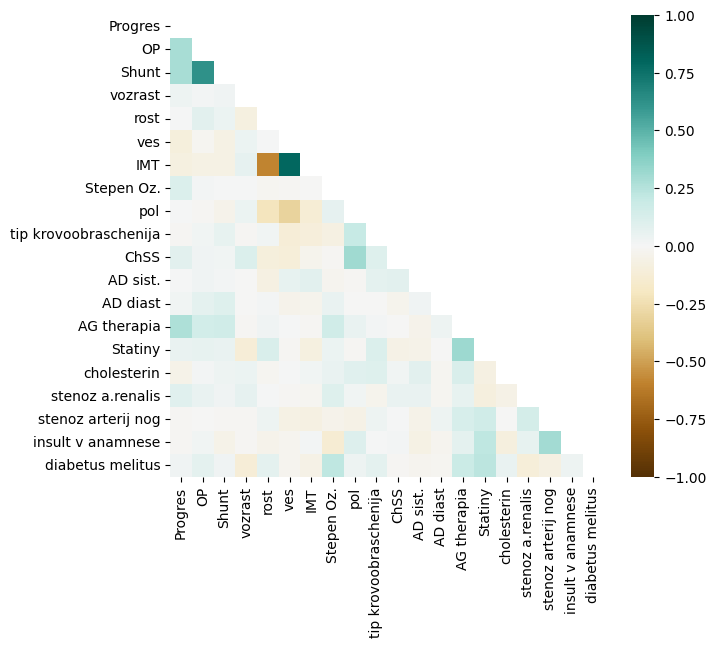

In [7]:
# lets look at correlation between fetures

# applying mask
plt.figure(figsize=(7, 6))
mask = np.triu(np.ones_like(df.corr()))
# plotting a triangle correlation heatmap
dataplot = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, cmap='BrBG')
# displaying heatmap
plt.show()

In [8]:
# Помічаємо, що ІМТ -- це комбінація росту та ваги, тому видаляємо цю колонку також
df.drop(['IMT'], axis=1, inplace=True)

Візьмемо колонку AG therapia (Антигіпертензивна терапія) за цільову змінну.

Метою роботи буде побудова моделі, яка буде передбачати чи потрібно клієнту назанчати даний вид терапії чи ні

Всі інші колонки (крім тих, що я видалив не минулому кроці) беремо за ознаки (фічі)

In [9]:
predictors = df.columns.to_list()
predictors.remove('AG therapia')
df['AG therapia'] = df['AG therapia']-1

# Моделювання

In [10]:
# розділення даних
X_train, X_test, y_train, y_test = train_test_split(df[predictors], df['AG therapia'], test_size=0.25, random_state=2)

In [11]:
# в якості моделі обираємо RandomForestClassifier
# бейзлайн на параметрах за замовченням та глибиною дерев 2
clf = RandomForestClassifier(random_state=42, max_depth=2)

# for evaluation we will use kfold cross-validation
cv = KFold(n_splits=5,random_state=42, shuffle=True)
results = cross_validate(clf, X_train, y_train, scoring='average_precision',cv=cv, return_train_score=True)

print('train average_precision', np.mean(results['train_score']))
print('val average_precision', np.mean(results['test_score']))
print('overgitting', np.mean(results['train_score']) - np.mean(results['test_score']))

clf = clf.fit(X_train,y_train)
print('test average_precision', average_precision_score(y_test,clf.predict_proba(X_test)[:,1]))

out_of_sample = cross_val_predict(clf, X_train, y_train, cv=cv, method='predict_proba')[:,1]

train average_precision 0.9255964177044385
val average_precision 0.8634981197234181
overgitting 0.0620982979810204
test average_precision 0.8248315193378494


In [12]:
# знайдемо найкращі параметри методом повного переобору
param_grid = {
    'n_estimators': [25, 50, 100, 150, 200, 300],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': list(range(1,5)),
    'max_leaf_nodes': [3, 6, 9, 12],
    'criterion':['gini', 'entropy', 'log_loss']
}

grid_search = GridSearchCV(RandomForestClassifier(), scoring='average_precision',
                            param_grid=param_grid, verbose=1, cv=3, n_jobs=1,
                            return_train_score = True)

In [13]:
# перевіряємо найкращі парметри
clf = RandomForestClassifier(max_depth=2, max_features='sqrt', n_estimators=100, random_state=42)
out_of_sample = cross_val_predict(clf, X_train, y_train, cv=cv, method='predict_proba')[:,1]
clf = clf.fit(X_train,y_train)
print('out_of_sample average_precision', average_precision_score(y_train ,out_of_sample))
print('test average_precision', average_precision_score(y_test,clf.predict_proba(X_test)[:,1]))

out_of_sample average_precision 0.8473082477029956
test average_precision 0.8248315193378494


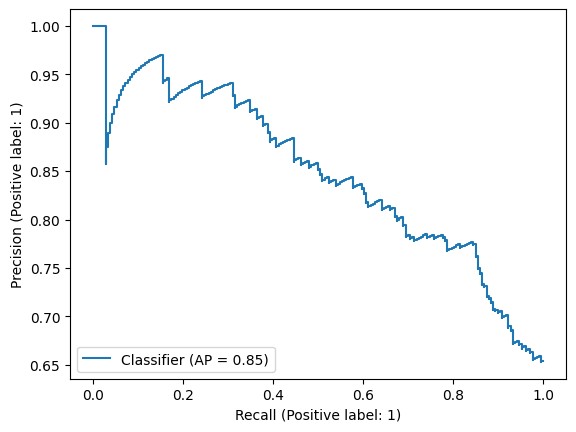

In [14]:
# подивимось на Precision-Recall криву
PrecisionRecallDisplay.from_predictions(y_train,out_of_sample)
plt.show()

In [15]:
# Обираємо трешхолд (найкраще значення f1)
precision, recall, thresholds= precision_recall_curve(y_train,out_of_sample)
find_threshold = pd.DataFrame()
find_threshold['precision'] = precision*100
find_threshold['recall'] = recall*100
find_threshold['f1_metric'] = (2*find_threshold.precision*find_threshold.recall)/(
                                    find_threshold.precision+find_threshold.recall)
find_threshold['threshold'] = np.insert(thresholds,0,0.0)

threshold = find_threshold[find_threshold.f1_metric == find_threshold.f1_metric.max()].threshold.to_list()[0]
find_threshold[find_threshold.f1_metric == find_threshold.f1_metric.max()]

,precision,recall,f1_metric,threshold
89,77.433628,84.951456,81.018519,0.610618


# Передбачення на тестових даних

In [16]:
# робимо передбачення на тест сет
test_prediction = (clf.predict_proba(X_test)[:,1]>threshold).astype(int)
print(classification_report(y_test,test_prediction))

              precision    recall  f1-score   support

           0       0.66      0.66      0.66        41
           1       0.78      0.78      0.78        64

    accuracy                           0.73       105
   macro avg       0.72      0.72      0.72       105
weighted avg       0.73      0.73      0.73       105



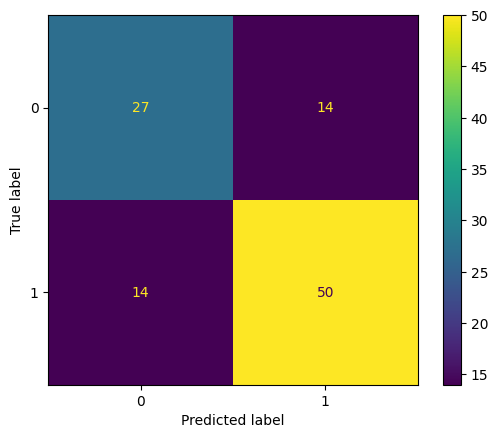

In [17]:
# вивдоимо матрицю помилок
cnf_m=confusion_matrix(y_test, test_prediction)
disp = ConfusionMatrixDisplay(cnf_m)
disp.plot()
plt.show()

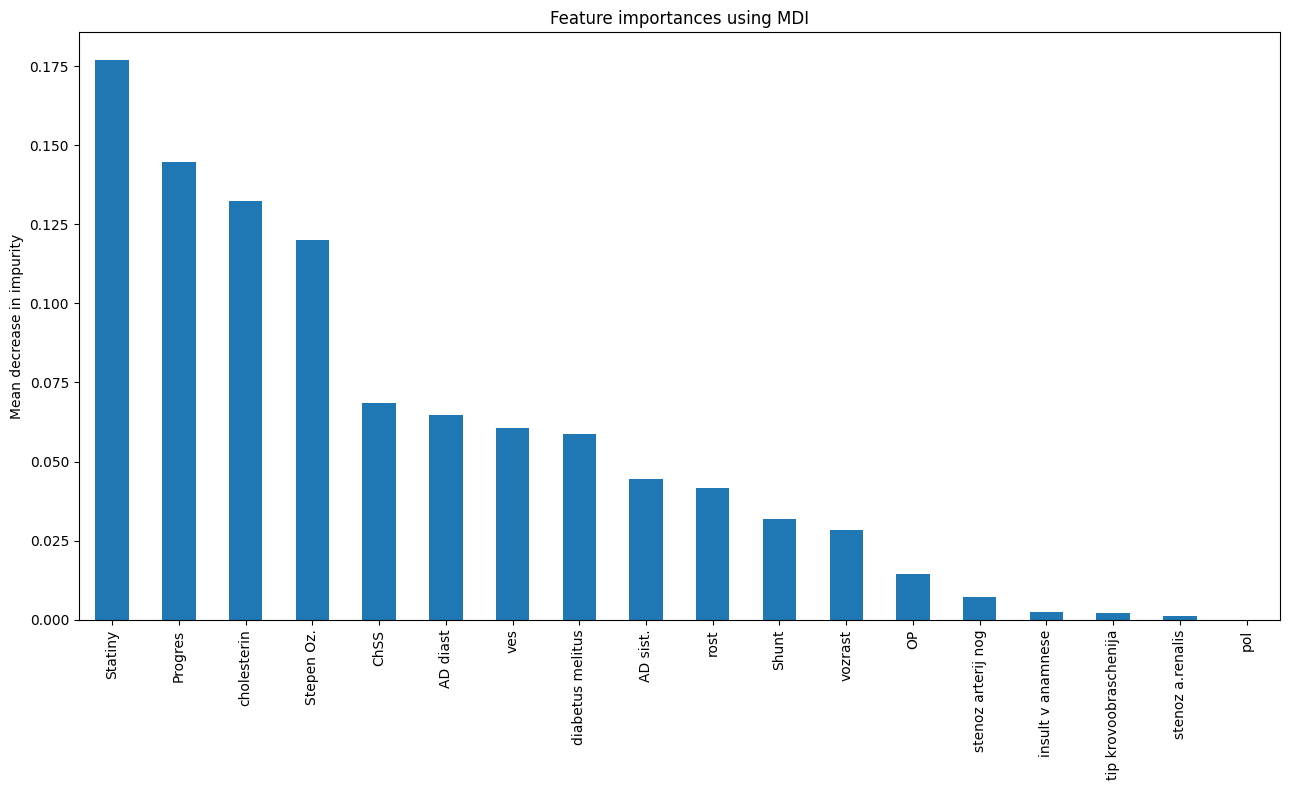

In [18]:
# подивимося які ознаки вплинули на результат
importances = clf.feature_importances_

forest_importances = pd.Series(importances, index=predictors)
forest_importances = forest_importances.sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(13, 8))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Висновки

Ми бачимо, що нам вдалося побудувати модель яка з точністю 78% знайшла 78% пацієнтів яким була наобхідна антигіпертензивна терапія.

Якщо б ми використовували наївний метод (абсолютно всім клієнтам назначати антигіпертензивна терапію), то знайшли б 100% пацієнтів але з точністю всього 64%.

Як бачимо модель вийшла не дуже сильна, можемо зробити висновок що 315-ти прикладів, які були відведені на навчання просто мало, щоб описати такі складні дані